# Analyse hydrogen market results from Pypsa-Earth network
This notebook analyze the hydrogen market data of the network (.nc) file. It generates comprehensive plots and summaries to visualize the results.
* Hydrogen Market Value
* Hydrogen Production Cost
* Hydrogen Capacity 
* Hydrogen Export 

Sources: 
- locAL DEcarbonization and HYDrogen Export: https://github.com/energyLS/aldehyde 
- Statistics module: https://pypsa.readthedocs.io/en/latest/examples/statistics.html
- Templates and colors: https://github.com/pypsa-meets-earth/documentation/blob/main/notebooks/network_analysis.ipynb

File is needed:
* PyPSA network file (.nc) includes the hydrogen financing information.

## Import packages

In [104]:
import yaml
import pypsa
import warnings
import matplotlib.pyplot as plt

## Path settings
This section reads the config parameters from your config.yaml file and automatically reads the output of the optimization with those settings

In [105]:
# Set your pypsa-earth directory here
PARENT = "/home/pypsa-earth/"
# Set your network path (.nc) here
network_path = PARENT + f"results/networks/elec_s_10_ec_lc3.0_Co2L_3H_2035_0.071_AB_14export.nc"
n = pypsa.Network(network_path)
statistics = n.statistics()
config_path = PARENT + f"/config.yaml"
config = yaml.safe_load(open(config_path))

### Hydrogen Market

In [106]:
# Hydrogen Market Value
h2_market = (statistics.loc["Link", "H2 Electrolysis"]["Market Value"]).round(2)
print(f"Yearly Hydrogen Market Value is: {h2_market} €")

Yearly Hydrogen Market Value is: 12.82 €


### Hydrogen Costs

In [107]:
h2_capex = (
        statistics.loc["Link", "H2 Electrolysis"]
        .loc["Capital Expenditure"]
        / 1e6
)  # in Mio. €
print(f"Capital Expenditure is: {h2_capex.round(2)} Mio. €")

h2_opex = (
    statistics.loc["Link", "H2 Electrolysis"]
    .loc["Operational Expenditure"]
    / 1e6
)  # in Mio. €
print(f"Operational Expenditure is: {h2_opex.round(2)} Mio. €")

hydrogen_production = (
    statistics.loc["Link", "H2 Electrolysis"]
    .loc["Supply"]
    .sum() 
    / 1e6
)  # in TWh

total_hydrogen_production_cost = h2_capex + h2_opex
hydrogen_cost_per_unit = total_hydrogen_production_cost / hydrogen_production

# Print Results
print(f"Total Hydrogen Production Cost: {total_hydrogen_production_cost.round(2)} Mio. €")
print(f"Hydrogen Production Cost per Unit: {hydrogen_cost_per_unit.round(2)} Mio. € per TWh")


Capital Expenditure is: 210.45 Mio. €
Operational Expenditure is: 0.22 Mio. €
Total Hydrogen Production Cost: 210.66 Mio. €
Hydrogen Production Cost per Unit: 12.82 Mio. € per TWh


### Hydrogen Exports

#### H2 Export on a hourly basis

<AxesSubplot:title={'center':'Hourly Hydrogen Export Prices'}, xlabel='Time', ylabel='Units: (€ / MWh)'>

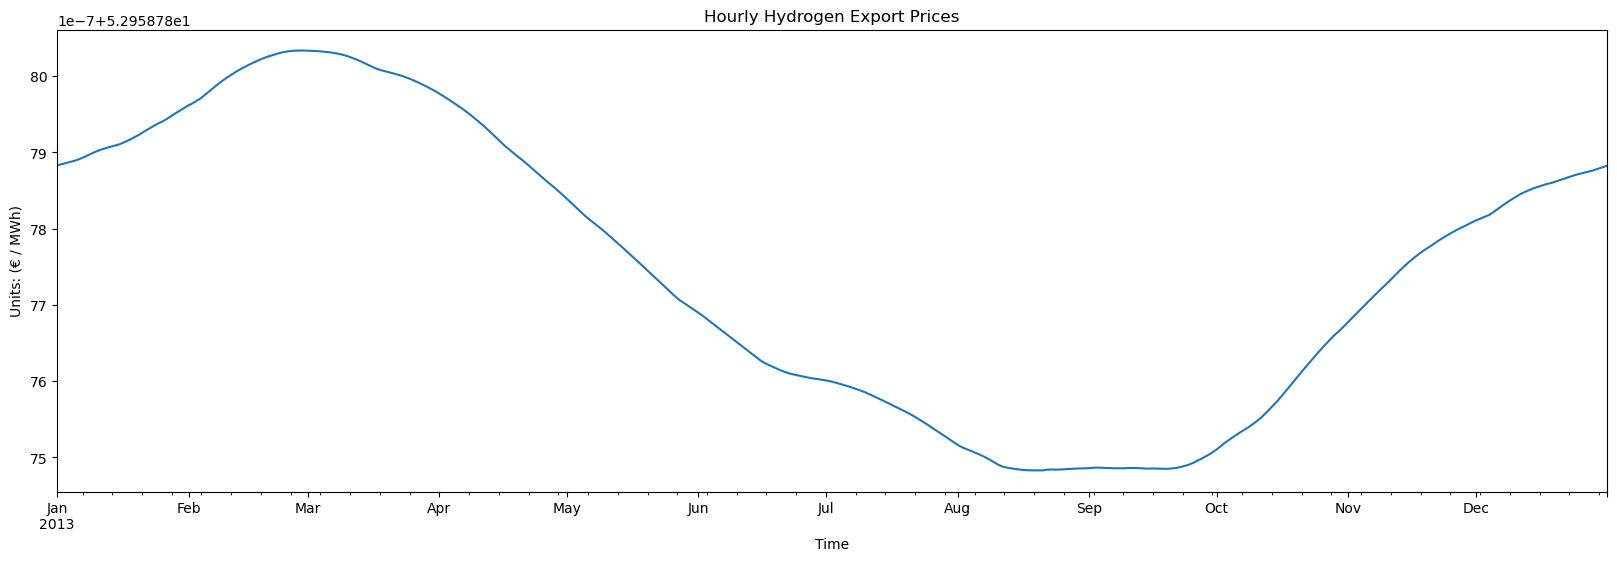

In [108]:
# Hourly hydrogen export prices
hydrogen_buses = n.buses[n.buses.index.str.contains("H2", case=False)]
hydrogen_prices = n.buses_t.marginal_price[hydrogen_buses.index]
hydrogen_export_prices = hydrogen_prices["H2 export bus"]
hydrogen_export_prices.plot(
    title="Hourly Hydrogen Export Prices",
    xlabel="Time",
    ylabel="Units: (€ / MWh)",
    figsize=(20, 6)
)

<AxesSubplot:title={'center':'Hourly Hydrogen Export Capacities'}, xlabel='Time', ylabel='Units: (MWh)'>

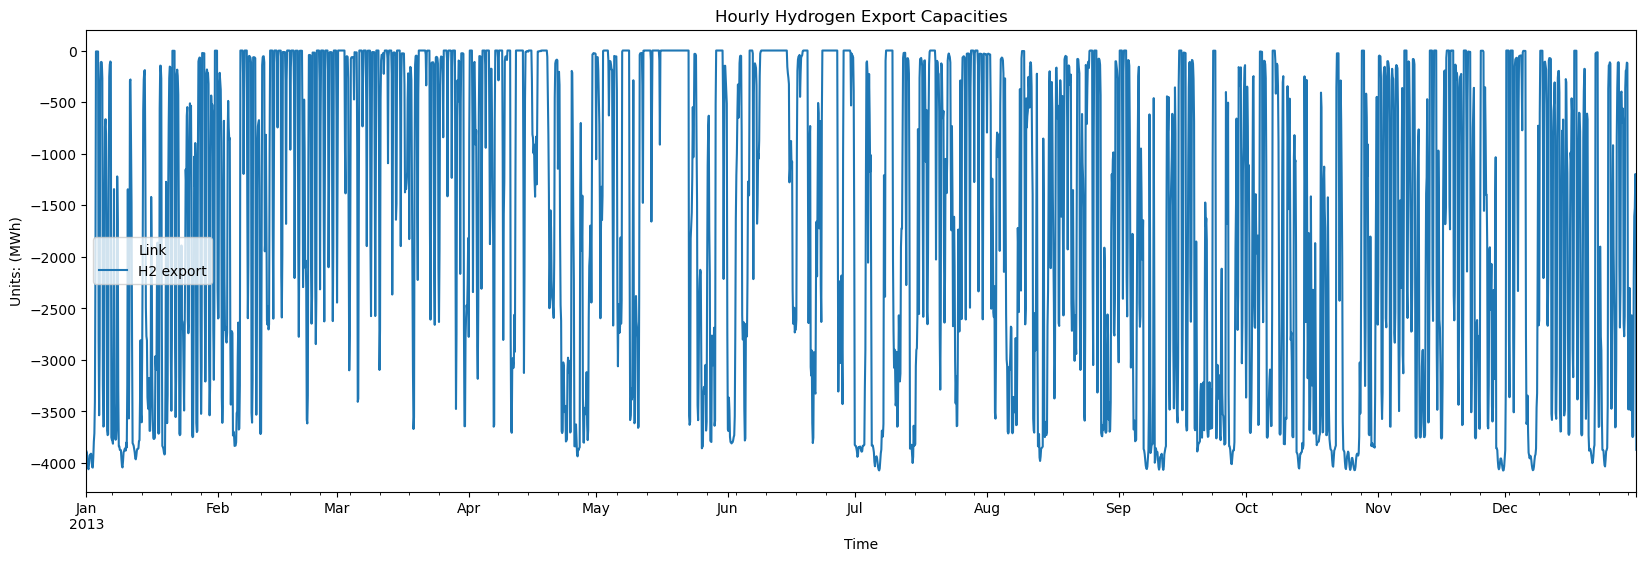

In [109]:
# Hourly hydrogen export capacities
hydrogen_export_links = n.links[n.links["carrier"] == "H2"]
hydrogen_export_capacity = n.links_t.p1[hydrogen_export_links.index]
hydrogen_export_capacity_cp = hydrogen_export_capacity.copy()

# Sum the 2 export columns into a new column named 'H2 export'
hydrogen_export_capacity_cp["H2 export"] = (
    hydrogen_export_capacity_cp["NZ.1_1_AC H2 export"] +
    hydrogen_export_capacity_cp["NZ.8_1_AC H2 export"]
)

# Drop the original separate export columns 
hydrogen_export_capacity_cp = hydrogen_export_capacity_cp.drop(
    ["NZ.1_1_AC H2 export", "NZ.8_1_AC H2 export"], axis=1
)

hydrogen_export_capacity_cp.plot(
    title="Hourly Hydrogen Export Capacities",
    xlabel="Time",
    ylabel="Units: (MWh)",
    figsize=(20, 6)
)

<AxesSubplot:title={'center':'Hourly Hydrogen Export Revenue'}, xlabel='Time', ylabel='Units: (€)'>

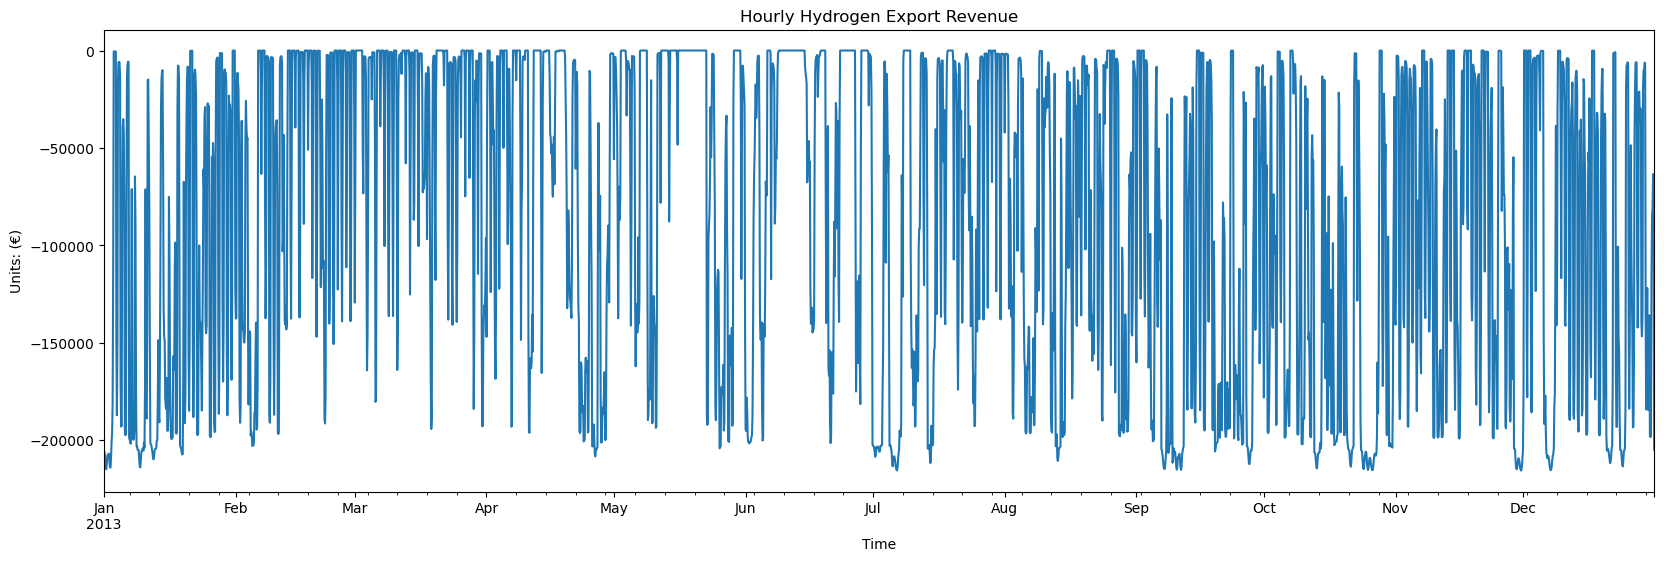

In [110]:
# Revenue
hydrogen_export_capacity.set_index(hydrogen_export_prices.index, inplace=True)
hydrogen_export_capacity_cp["Hourly Revenue"] = (
    hydrogen_export_capacity_cp["H2 export"] * hydrogen_export_prices
)

hydrogen_export_capacity_cp["Hourly Revenue"].plot(
    title="Hourly Hydrogen Export Revenue",
    xlabel="Time",
    ylabel="Units: (€)",
    figsize=(20, 6)
)

#### H2 Export on a yearly basis

In [111]:
H2_export_TWh = n.statistics.energy_balance(comps=["Load"]).loc[:,"H2"].values[0]/1e6 # in TWh
print(f"Yearly Hydrogen Export Capacity is: {H2_export_TWh} TWh")
H2_export_revenue = H2_export_TWh*h2_market
print(f"Hydrogen Export Revenue (yearly) is: {H2_export_revenue.round(2)} Mio. €")

Yearly Hydrogen Export Capacity is: -14.0 TWh
Hydrogen Export Revenue (yearly) is: -179.48 Mio. €


### Hydrogen Capacity

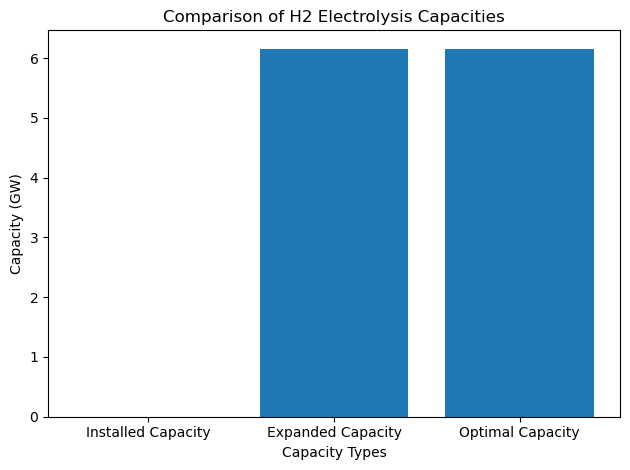

In [112]:
installed_capacity = n.statistics.installed_capacity(comps='Link').loc["H2 Electrolysis"]/ 1e3
expanded_capacity = n.statistics.expanded_capacity(comps='Link').loc["H2 Electrolysis"]/ 1e3
optimal_capacity = n.statistics.optimal_capacity(comps='Link').loc["H2 Electrolysis"]/ 1e3

categories = ['Installed Capacity', 'Expanded Capacity', 'Optimal Capacity']
values = [installed_capacity, expanded_capacity, optimal_capacity]

plt.figure()
plt.bar(categories, values)
plt.title('Comparison of H2 Electrolysis Capacities')
plt.ylabel('Capacity (GW)') 
plt.xlabel('Capacity Types')
plt.tight_layout()
plt.show()